# Race

In [1]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Data processing
from sklearn.model_selection import train_test_split

# Models
# LightGBM is a gradient boosting framework that uses tree based learning algorithms
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV

# Fairlearn algorithms and utils
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import GridSearch, EqualizedOdds

# Metrics
from fairlearn.metrics import (
    MetricFrame,
    selection_rate, demographic_parity_difference, demographic_parity_ratio,
    true_positive_rate, false_positive_rate, false_negative_rate,
    false_positive_rate_difference, false_negative_rate_difference,
    equalized_odds_difference)
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

In [2]:
# load the clean data
d = 'data/Fairlearn_DC.csv'
d = pd.read_csv(d, sep = ',')
d.head()

,ethnicity,race,gender,action_taken,preapproval_requested,loan_type,loan_purpose,interest_only_payment,balloon_payment,debt_to_income_ratio,age,income,loan_to_value_ratio
0,0,1,0,1,0,1,1,2,2,3,3,1,1
1,0,1,1,1,0,3,3,2,2,4,3,3,1
2,0,2,0,1,0,1,3,2,2,4,2,3,3
3,0,1,0,1,0,1,3,2,2,2,3,5,1
4,0,3,0,1,0,1,1,2,2,4,3,2,1


In [3]:
# Extract the sensitive feature - example: race
A = d["race"].apply(lambda x:1 if x == 1 else 0)
A_str = A.map({ 1:"White", 0:"Non-White"})
A_str

0            White
1            White
2        Non-White
3            White
4        Non-White
           ...    
89150    Non-White
89151        White
89152        White
89153    Non-White
89154        White
Name: race, Length: 89155, dtype: object

In [4]:
# Extract the target
Y = d["action_taken"]
categorical_features = ['preapproval_requested', 'loan_type','loan_purpose', 'interest_only_payment', 'balloon_payment', 'debt_to_income_ratio', 'income']
for col in categorical_features:
    d[col] = d[col].astype('category')
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89155 entries, 0 to 89154
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   ethnicity              89155 non-null  int64   
 1   race                   89155 non-null  int64   
 2   gender                 89155 non-null  int64   
 3   action_taken           89155 non-null  int64   
 4   preapproval_requested  89155 non-null  category
 5   loan_type              89155 non-null  category
 6   loan_purpose           89155 non-null  category
 7   interest_only_payment  89155 non-null  category
 8   balloon_payment        89155 non-null  category
 9   debt_to_income_ratio   89155 non-null  category
 10  age                    89155 non-null  int64   
 11  income                 89155 non-null  category
 12  loan_to_value_ratio    89155 non-null  int64   
dtypes: category(7), int64(6)
memory usage: 4.7 MB


In [5]:
# Train-test split
df_train, df_test, Y_train, Y_test, A_train, A_test, A_str_train, A_str_test = train_test_split(
    d.drop(columns=['race', 'action_taken', 'ethnicity', 'gender', 'age']), 
    Y, 
    A, 
    A_str,
    test_size = 0.3, 
    random_state=12345,
    stratify=Y)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62408 entries, 75761 to 33478
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   preapproval_requested  62408 non-null  category
 1   loan_type              62408 non-null  category
 2   loan_purpose           62408 non-null  category
 3   interest_only_payment  62408 non-null  category
 4   balloon_payment        62408 non-null  category
 5   debt_to_income_ratio   62408 non-null  category
 6   income                 62408 non-null  category
 7   loan_to_value_ratio    62408 non-null  int64   
dtypes: category(7), int64(1)
memory usage: 1.4 MB


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62408 entries, 75761 to 33478
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   preapproval_requested  62408 non-null  category
 1   loan_type              62408 non-null  category
 2   loan_purpose           62408 non-null  category
 3   interest_only_payment  62408 non-null  category
 4   balloon_payment        62408 non-null  category
 5   debt_to_income_ratio   62408 non-null  category
 6   income                 62408 non-null  category
 7   loan_to_value_ratio    62408 non-null  int64   
dtypes: category(7), int64(1)
memory usage: 1.4 MB


## Using a Fairness Unaware Model

In [8]:
lgb_params = {
    'objective' : 'binary',
    'metric' : 'auc',
    'learning_rate': 0.03,
    'num_leaves' : 10,
    'max_depth' : 3
}

In [9]:
model = lgb.LGBMClassifier(**lgb_params)

In [10]:
model.fit(df_train, Y_train)

LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary')

In [11]:
# Scores on test set
test_scores = model.predict_proba(df_test)[:, 1]

In [12]:
# Train AUC
roc_auc_score(Y_train, model.predict_proba(df_train)[:, 1])

0.8444153179566672

In [13]:
# Predictions (0 or 1) on test set
test_preds = (test_scores >= np.mean(Y_train)) * 1

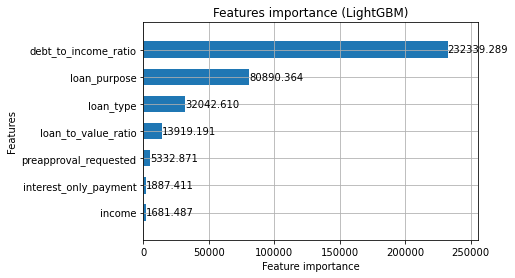

In [14]:
# LightGBM feature importance 
lgb.plot_importance(model, height=0.6, title="Features importance (LightGBM)", importance_type="gain", max_num_features=15) 
plt.show()

We next use Fairlearn's `MetricFrame` to examine the the two different kinds of errors (false positives and false negatives) on the test data.

In [15]:
mf = MetricFrame({
    'FPR': false_positive_rate,
    'FNR': false_negative_rate},
    Y_test, test_preds, sensitive_features=A_str_test)

mf.by_group

C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\metrics\_metric_frame.py:63: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(f"You have provided {args_msg} as positional arguments. "


,FPR,FNR
race,,
Non-White,0.33186,0.146432
White,0.317308,0.139082


In [20]:
# Helper functions
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Overall selection rate": (
            lambda x: selection_rate(y_true, x), True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
        "Demographic parity ratio": (
            lambda x: demographic_parity_ratio(y_true, x, sensitive_features=group), True),
        "------": (lambda x: "", True),
        "Overall balanced error rate": (
            lambda x: balanced_accuracy_score(y_true, x), True),
        "Balanced error rate difference": (
            lambda x: MetricFrame(metrics=balanced_accuracy_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), True),
        " ------": (lambda x: "", True),
        # defined by team6 - equal opportunity - the percentage of people that have rightfully benefitted from the loan model
        "True positive rate": (
            lambda x: true_positive_rate(y_true, x), True),
        # defined by team6 - equalized odds - the percentage of people that have wrongfully benefitted from the loan model
        "False positive rate difference": (
            lambda x: false_positive_rate_difference(y_true, x, sensitive_features=group), True),
        "False negative rate difference": (
            lambda x: false_negative_rate_difference(y_true, x, sensitive_features=group), True),
        # defined by UCI Ex - 0 means that all groups have the same true positive, true negative, false positive, and false negative rates.)
        "Equalized odds difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
        "  ------": (lambda x: "", True),
        "Overall AUC": (
            lambda x: roc_auc_score(y_true, x), False),
        "AUC difference": (
            lambda x: MetricFrame(metrics=roc_auc_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), False),
    }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

We calculate several performance and fairness metrics below:

In [17]:
# Metrics
models_dict = {"Unmitigated": (test_preds, test_scores)}
get_metrics_df(models_dict, Y_test, A_str_test)

,Unmitigated
Overall selection rate,0.732082
Demographic parity difference,0.065589
Demographic parity ratio,0.913861
------,
Overall balanced error rate,0.766138
Balanced error rate difference,0.010951
------,
True positive rate,0.857912
False positive rate difference,0.014552
False negative rate difference,0.00735


## Mitigating Equalized Odds Difference with Postprocessing

We attempt to mitigate the disparities in the `lightgbm` predictions using the Fairlearn postprocessing algorithm `ThresholdOptimizer`. This algorithm finds a suitable threshold for the scores (class probabilities) produced by the `lightgbm` model by optimizing the accuracy rate under the constraint that the equalized odds difference (on training data) is zero. Since our goal is to optimize balanced accuracy, we resample the training data to have the same number of positive and negative examples. This means that `ThresholdOptimizer` is effectively optimizing balanced accuracy on the original data.

In [18]:
postprocess_est = ThresholdOptimizer(
    estimator=model,
    constraints="equalized_odds",
    prefit=True)

In [19]:
# Balanced data set is obtained by sampling the same number of points from the majority class (Y=0)
# as there are points in the minority class (Y=1)
balanced_idx1 = df_train[Y_train==1].index
pp_train_idx = balanced_idx1.union(Y_train[Y_train==0].sample(n=balanced_idx1.size, random_state=1234, replace=True).index)

In [20]:
df_train_balanced = df_train.loc[pp_train_idx, :]
Y_train_balanced = Y_train.loc[pp_train_idx]
A_train_balanced = A_train.loc[pp_train_idx]

In [21]:
postprocess_est.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)

C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\postprocessing\_threshold_optimizer.py:270: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(


ThresholdOptimizer(constraints='equalized_odds',
                   estimator=LGBMClassifier(learning_rate=0.03, max_depth=3,
                                            metric='auc', num_leaves=10,
                                            objective='binary'),
                   prefit=True)

In [22]:
postprocess_preds = postprocess_est.predict(df_test, sensitive_features=A_test)

In [23]:
models_dict = {"Unmitigated": (test_preds, test_scores),
              "ThresholdOptimizer": (postprocess_preds, postprocess_preds)}
get_metrics_df(models_dict, Y_test, A_str_test)

,Unmitigated,ThresholdOptimizer
Overall selection rate,0.732082,0.877706
Demographic parity difference,0.065589,0.051869
Demographic parity ratio,0.913861,0.942427
------,,
Overall balanced error rate,0.766138,0.706362
Balanced error rate difference,0.010951,0.003278
------,,
True positive rate,0.857912,0.975274
False positive rate difference,0.014552,0.007667
False negative rate difference,0.00735,0.001112


The `ThresholdOptimizer` algorithm significantly reduces the disparity according to multiple metrics. However, the performance metrics (balanced error rate as well as AUC) get worse. Before deploying such a model in practice, it would be important to examine in more detail why we observe such a sharp trade-off. In our case it is because the available features are much less informative for one of the demographic groups than for the other.

Note that unlike the unmitigated model, `ThresholdOptimizer` produces 0/1 predictions, so its balanced error rate difference is equal to the AUC difference, and its overall balanced error rate is equal to 1 - overall AUC.

## Mitigating Equalized Odds Difference with GridSearch

We now attempt to mitigate disparities using the `GridSearch` algorithm. Unlike `ThresholdOptimizer`, the predictors produced by `GridSearch` do not access the sensitive feature at test time. Also, rather than training a single model, we train multiple models corresponding to different trade-off points between the performance metric (balanced accuracy) and fairness metric (equalized odds difference).

In [24]:
# Train GridSearch
sweep = GridSearch(model,
                   constraints=EqualizedOdds(),
                   grid_size=1000,
                   grid_limit=10)

sweep.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)

C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and

Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambda_vecs_[i] = lambda_vec
C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_grid_search\grid_search.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas_[i] = self.constraints.gamma(predict_fct)


In [25]:
sweep_preds = [predictor.predict(df_test) for predictor in sweep.predictors_] 
sweep_scores = [predictor.predict_proba(df_test)[:, 1] for predictor in sweep.predictors_]

In [26]:
equalized_odds_sweep = [
    equalized_odds_difference(Y_test, preds, sensitive_features=A_str_test)
    for preds in sweep_preds
]
balanced_accuracy_sweep = [balanced_accuracy_score(Y_test, preds) for preds in sweep_preds]
auc_sweep = [roc_auc_score(Y_test, scores) for scores in sweep_scores]

In [27]:
# Select only non-dominated models (with respect to balanced accuracy and equalized odds difference)
all_results = pd.DataFrame(
    {"predictor": sweep.predictors_, "accuracy": balanced_accuracy_sweep, "disparity": equalized_odds_sweep}
) 
non_dominated = [] 
for row in all_results.itertuples(): 
    accuracy_for_lower_or_eq_disparity = all_results["accuracy"][all_results["disparity"] <= row.disparity] 
    if row.accuracy >= accuracy_for_lower_or_eq_disparity.max(): 
        non_dominated.append(True)
    else:
        non_dominated.append(False)

equalized_odds_sweep_non_dominated = np.asarray(equalized_odds_sweep)[non_dominated]
balanced_accuracy_non_dominated = np.asarray(balanced_accuracy_sweep)[non_dominated]
auc_non_dominated = np.asarray(auc_sweep)[non_dominated]

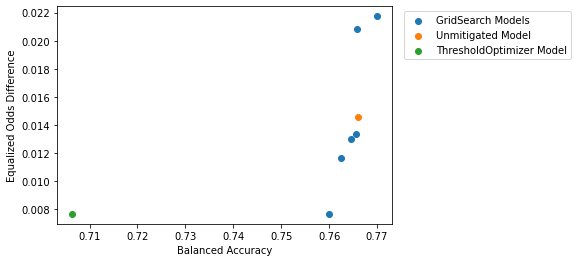

In [28]:
# Plot equalized odds difference vs balanced accuracy
plt.scatter(balanced_accuracy_non_dominated, equalized_odds_sweep_non_dominated, label="GridSearch Models")
plt.scatter(balanced_accuracy_score(Y_test, test_preds),
            equalized_odds_difference(Y_test, test_preds, sensitive_features=A_str_test), 
            label="Unmitigated Model")
plt.scatter(balanced_accuracy_score(Y_test, postprocess_preds), 
            equalized_odds_difference(Y_test, postprocess_preds, sensitive_features=A_str_test),
            label="ThresholdOptimizer Model")
plt.xlabel("Balanced Accuracy")
plt.ylabel("Equalized Odds Difference")
plt.legend(bbox_to_anchor=(1.55, 1))
plt.show()

As intended, `GridSearch` models appear along the trade-off curve between the large balanced accuracy (but also large disparity), and low disparity (but worse balanced accuracy). This gives the data scientist a flexibility to select a model that fits the application context best.

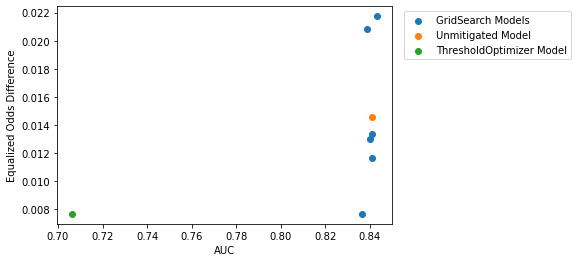

In [29]:
# Plot equalized odds difference vs AUC
plt.scatter(auc_non_dominated, equalized_odds_sweep_non_dominated, label="GridSearch Models")
plt.scatter(roc_auc_score(Y_test, test_scores),
            equalized_odds_difference(Y_test, test_preds, sensitive_features=A_str_test), 
            label="Unmitigated Model")
plt.scatter(roc_auc_score(Y_test, postprocess_preds), 
            equalized_odds_difference(Y_test, postprocess_preds, sensitive_features=A_str_test),
            label="ThresholdOptimizer Model")
plt.xlabel("AUC")
plt.ylabel("Equalized Odds Difference")
plt.legend(bbox_to_anchor=(1.55, 1))
plt.show()

Similarly, `GridSearch` models appear along the trade-off curve between AUC and equalized odds difference.

In [30]:
# Compare GridSearch models with low values of equalized odds difference with the previously constructed models
grid_search_dict = {"GridSearch_{}".format(i): (sweep_preds[i], sweep_scores[i])
                    for i in range(len(sweep_preds))
                    if non_dominated[i] and equalized_odds_sweep[i]<0.1}
models_dict.update(grid_search_dict)
get_metrics_df(models_dict, Y_test, A_str_test)

,Unmitigated,ThresholdOptimizer,GridSearch_421,GridSearch_505,GridSearch_506,GridSearch_548,GridSearch_549,GridSearch_590
Overall selection rate,0.732082,0.877706,0.728269,0.71522,0.733129,0.712865,0.697125,0.695667
Demographic parity difference,0.065589,0.051869,0.071388,0.07907,0.066426,0.078133,0.060679,0.057283
Demographic parity ratio,0.913861,0.942427,0.906096,0.894659,0.912925,0.895522,0.916222,0.920584
------,,,,,,,,
Overall balanced error rate,0.766138,0.706362,0.764573,0.769906,0.765581,0.765878,0.76251,0.759898
Balanced error rate difference,0.010951,0.003278,0.009633,0.014221,0.010807,0.012227,0.006314,0.001844
------,,,,,,,,
True positive rate,0.857912,0.975274,0.853359,0.842832,0.858696,0.838572,0.82124,0.818547
False positive rate difference,0.014552,0.007667,0.00625,0.006699,0.013345,0.003639,0.011617,0.007638
False negative rate difference,0.00735,0.001112,0.013016,0.021742,0.00827,0.020815,0.001012,0.003949


## Conclusion

In this notebook, we explored how a fairness-unaware gradient boosted trees model performed on the classification task in contrast to the postprocessed `ThresholdOptimizer` model and the `GridSearch` model. The `ThresholdOptimizer` greatly reduced the disparity in performance across multiple fairness metrics. However the overall error rate and AUC for the `ThresholdOptimizer` model were worse compared to the fairness-unaware model. 

With the `GridSearch` algorithm, we trained multiple models that balance the trade-off between the balanced accuracy and the equalized odds fairness metric. After engaging with relevant stakeholders, the data scientist can deploy the model that balances the performance-fairness trade-off that meets the needs of the business.

# Age

In [2]:
# load the clean data
d = 'data/Fairlearn_DC.csv'
d = pd.read_csv(d, sep = ',')
d.head()

,ethnicity,race,gender,action_taken,preapproval_requested,loan_type,loan_purpose,interest_only_payment,balloon_payment,debt_to_income_ratio,age,income,loan_to_value_ratio
0,0,1,0,1,0,1,1,2,2,3,3,1,1
1,0,1,1,1,0,3,3,2,2,4,3,3,1
2,0,2,0,1,0,1,3,2,2,4,2,3,3
3,0,1,0,1,0,1,3,2,2,2,3,5,1
4,0,3,0,1,0,1,1,2,2,4,3,2,1


In [6]:
# Extract the sensitive feature - example: age - middle-aged vs non m-a
B = d["age"].apply(lambda x:1 if x == 2 else 0)
B_str = B.map({ 1:"Middle-Aged", 0:"Non-Middle-Aged"})
B_str

0        Non-Middle-Aged
1        Non-Middle-Aged
2            Middle-Aged
3        Non-Middle-Aged
4        Non-Middle-Aged
              ...       
89150    Non-Middle-Aged
89151    Non-Middle-Aged
89152        Middle-Aged
89153    Non-Middle-Aged
89154    Non-Middle-Aged
Name: age, Length: 89155, dtype: object

In [7]:
# Extract the target
Y = d["action_taken"]
categorical_features = ['preapproval_requested', 'loan_type','loan_purpose', 'interest_only_payment', 'balloon_payment', 'debt_to_income_ratio', 'income']
for col in categorical_features:
    d[col] = d[col].astype('category')
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89155 entries, 0 to 89154
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   ethnicity              89155 non-null  int64   
 1   race                   89155 non-null  int64   
 2   gender                 89155 non-null  int64   
 3   action_taken           89155 non-null  int64   
 4   preapproval_requested  89155 non-null  category
 5   loan_type              89155 non-null  category
 6   loan_purpose           89155 non-null  category
 7   interest_only_payment  89155 non-null  category
 8   balloon_payment        89155 non-null  category
 9   debt_to_income_ratio   89155 non-null  category
 10  age                    89155 non-null  int64   
 11  income                 89155 non-null  category
 12  loan_to_value_ratio    89155 non-null  int64   
dtypes: category(7), int64(6)
memory usage: 4.7 MB


In [8]:
# Train-test split
df_train, df_test, Y_train, Y_test, B_train, B_test, B_str_train, B_str_test = train_test_split(
    d.drop(columns=['race', 'action_taken', 'ethnicity', 'gender', 'age']), 
    Y, 
    B, 
    B_str,
    test_size = 0.3, 
    random_state=12345,
    stratify=Y)

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62408 entries, 75761 to 33478
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   preapproval_requested  62408 non-null  category
 1   loan_type              62408 non-null  category
 2   loan_purpose           62408 non-null  category
 3   interest_only_payment  62408 non-null  category
 4   balloon_payment        62408 non-null  category
 5   debt_to_income_ratio   62408 non-null  category
 6   income                 62408 non-null  category
 7   loan_to_value_ratio    62408 non-null  int64   
dtypes: category(7), int64(1)
memory usage: 1.4 MB


## Using a Fairness Unaware Model

In [10]:
lgb_params = {
    'objective' : 'binary',
    'metric' : 'auc',
    'learning_rate': 0.03,
    'num_leaves' : 10,
    'max_depth' : 3
}

In [11]:
model = lgb.LGBMClassifier(**lgb_params)

In [12]:
model.fit(df_train, Y_train)

LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary')

In [13]:
# Scores on test set
test_scores = model.predict_proba(df_test)[:, 1]

In [14]:
# Train AUC
roc_auc_score(Y_train, model.predict_proba(df_train)[:, 1])

0.8444153179566672

In [15]:
# Predictions (0 or 1) on test set
test_preds = (test_scores >= np.mean(Y_train)) * 1

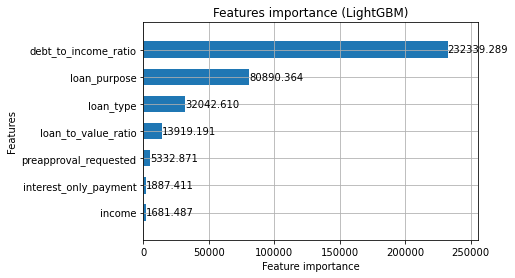

In [16]:
# LightGBM feature importance 
lgb.plot_importance(model, height=0.6, title="Features importance (LightGBM)", importance_type="gain", max_num_features=15) 
plt.show()

We next use Fairlearn's `MetricFrame` to examine the the two different kinds of errors (false positives and false negatives) on the test data.

In [18]:
mf = MetricFrame({
    'FPR': false_positive_rate,
    'FNR': false_negative_rate},
    Y_test, test_preds, sensitive_features=B_str_test)

mf.by_group

C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\metrics\_metric_frame.py:63: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(f"You have provided {args_msg} as positional arguments. "


,FPR,FNR
age,,
Middle-Aged,0.335514,0.143542
Non-Middle-Aged,0.315451,0.140507


We calculate several performance and fairness metrics below:

In [21]:
# Metrics
models_dict = {"Unmitigated": (test_preds, test_scores)}
get_metrics_df(models_dict, Y_test, B_str_test)

,Unmitigated
Overall selection rate,0.732082
Demographic parity difference,0.007506
Demographic parity ratio,0.989798
------,
Overall balanced error rate,0.766138
Balanced error rate difference,0.011549
------,
True positive rate,0.857912
False positive rate difference,0.020063
False negative rate difference,0.003035


## Mitigating Equalized Odds Difference with Postprocessing

We attempt to mitigate the disparities in the `lightgbm` predictions using the Fairlearn postprocessing algorithm `ThresholdOptimizer`. This algorithm finds a suitable threshold for the scores (class probabilities) produced by the `lightgbm` model by optimizing the accuracy rate under the constraint that the equalized odds difference (on training data) is zero. Since our goal is to optimize balanced accuracy, we resample the training data to have the same number of positive and negative examples. This means that `ThresholdOptimizer` is effectively optimizing balanced accuracy on the original data.

In [22]:
postprocess_est = ThresholdOptimizer(
    estimator=model,
    constraints="equalized_odds",
    prefit=True)

In [23]:
# Balanced data set is obtained by sampling the same number of points from the majority class (Y=0)
# as there are points in the minority class (Y=1)
balanced_idx1 = df_train[Y_train==1].index
pp_train_idx = balanced_idx1.union(Y_train[Y_train==0].sample(n=balanced_idx1.size, random_state=1234, replace=True).index)

In [30]:
df_train_balanced = df_train.loc[pp_train_idx, :]
Y_train_balanced = Y_train.loc[pp_train_idx]
B_train_balanced = B_train.loc[pp_train_idx]

In [31]:
postprocess_est.fit(df_train_balanced, Y_train_balanced, sensitive_features=B_train_balanced)

C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\postprocessing\_threshold_optimizer.py:270: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(


ThresholdOptimizer(constraints='equalized_odds',
                   estimator=LGBMClassifier(learning_rate=0.03, max_depth=3,
                                            metric='auc', num_leaves=10,
                                            objective='binary'),
                   prefit=True)

In [32]:
postprocess_preds = postprocess_est.predict(df_test, sensitive_features=B_test)

In [33]:
models_dict = {"Unmitigated": (test_preds, test_scores),
              "ThresholdOptimizer": (postprocess_preds, postprocess_preds)}
get_metrics_df(models_dict, Y_test, B_str_test)

,Unmitigated,ThresholdOptimizer
Overall selection rate,0.732082,0.888586
Demographic parity difference,0.007506,0.000878
Demographic parity ratio,0.989798,0.999012
------,,
Overall balanced error rate,0.766138,0.692568
Balanced error rate difference,0.011549,0.012815
------,,
True positive rate,0.857912,0.979632
False positive rate difference,0.020063,0.022357
False negative rate difference,0.003035,0.003272


The `ThresholdOptimizer` algorithm significantly reduces the disparity according to multiple metrics. However, the performance metrics (balanced error rate as well as AUC) get worse. Before deploying such a model in practice, it would be important to examine in more detail why we observe such a sharp trade-off. In our case it is because the available features are much less informative for one of the demographic groups than for the other.

Note that unlike the unmitigated model, `ThresholdOptimizer` produces 0/1 predictions, so its balanced error rate difference is equal to the AUC difference, and its overall balanced error rate is equal to 1 - overall AUC.

## Mitigating Equalized Odds Difference with GridSearch

We now attempt to mitigate disparities using the `GridSearch` algorithm. Unlike `ThresholdOptimizer`, the predictors produced by `GridSearch` do not access the sensitive feature at test time. Also, rather than training a single model, we train multiple models corresponding to different trade-off points between the performance metric (balanced accuracy) and fairness metric (equalized odds difference).

In [34]:
# Train GridSearch
sweep = GridSearch(model,
                   constraints=EqualizedOdds(),
                   grid_size=50,
                   grid_limit=3)

sweep.fit(df_train_balanced, Y_train_balanced, sensitive_features=B_train_balanced)

C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \


Finished loading model, total used 100 iterations


In [35]:
sweep_preds = [predictor.predict(df_test) for predictor in sweep.predictors_] 
sweep_scores = [predictor.predict_proba(df_test)[:, 1] for predictor in sweep.predictors_]

In [36]:
equalized_odds_sweep = [
    equalized_odds_difference(Y_test, preds, sensitive_features=B_str_test)
    for preds in sweep_preds
]
balanced_accuracy_sweep = [balanced_accuracy_score(Y_test, preds) for preds in sweep_preds]
auc_sweep = [roc_auc_score(Y_test, scores) for scores in sweep_scores]

In [37]:
# Select only non-dominated models (with respect to balanced accuracy and equalized odds difference)
all_results = pd.DataFrame(
    {"predictor": sweep.predictors_, "accuracy": balanced_accuracy_sweep, "disparity": equalized_odds_sweep}
) 
non_dominated = [] 
for row in all_results.itertuples(): 
    accuracy_for_lower_or_eq_disparity = all_results["accuracy"][all_results["disparity"] <= row.disparity] 
    if row.accuracy >= accuracy_for_lower_or_eq_disparity.max(): 
        non_dominated.append(True)
    else:
        non_dominated.append(False)

equalized_odds_sweep_non_dominated = np.asarray(equalized_odds_sweep)[non_dominated]
balanced_accuracy_non_dominated = np.asarray(balanced_accuracy_sweep)[non_dominated]
auc_non_dominated = np.asarray(auc_sweep)[non_dominated]

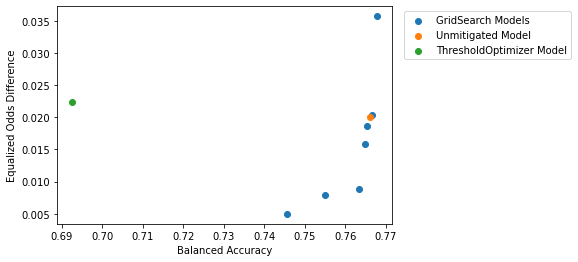

In [38]:
# Plot equalized odds difference vs balanced accuracy
plt.scatter(balanced_accuracy_non_dominated, equalized_odds_sweep_non_dominated, label="GridSearch Models")
plt.scatter(balanced_accuracy_score(Y_test, test_preds),
            equalized_odds_difference(Y_test, test_preds, sensitive_features=B_str_test), 
            label="Unmitigated Model")
plt.scatter(balanced_accuracy_score(Y_test, postprocess_preds), 
            equalized_odds_difference(Y_test, postprocess_preds, sensitive_features=B_str_test),
            label="ThresholdOptimizer Model")
plt.xlabel("Balanced Accuracy")
plt.ylabel("Equalized Odds Difference")
plt.legend(bbox_to_anchor=(1.55, 1))
plt.show()

As intended, `GridSearch` models appear along the trade-off curve between the large balanced accuracy (but also large disparity), and low disparity (but worse balanced accuracy). This gives the data scientist a flexibility to select a model that fits the application context best.

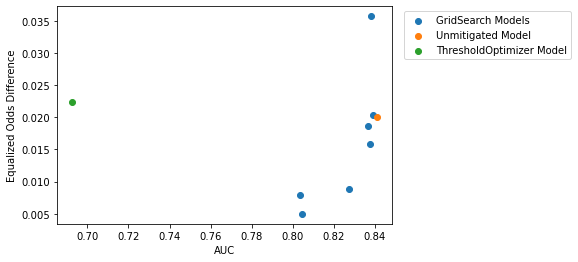

In [39]:
# Plot equalized odds difference vs AUC
plt.scatter(auc_non_dominated, equalized_odds_sweep_non_dominated, label="GridSearch Models")
plt.scatter(roc_auc_score(Y_test, test_scores),
            equalized_odds_difference(Y_test, test_preds, sensitive_features=B_str_test), 
            label="Unmitigated Model")
plt.scatter(roc_auc_score(Y_test, postprocess_preds), 
            equalized_odds_difference(Y_test, postprocess_preds, sensitive_features=B_str_test),
            label="ThresholdOptimizer Model")
plt.xlabel("AUC")
plt.ylabel("Equalized Odds Difference")
plt.legend(bbox_to_anchor=(1.55, 1))
plt.show()

Similarly, `GridSearch` models appear along the trade-off curve between AUC and equalized odds difference.

In [41]:
# Compare GridSearch models with low values of equalized odds difference with the previously constructed models
grid_search_dict = {"GridSearch_{}".format(i): (sweep_preds[i], sweep_scores[i])
                    for i in range(len(sweep_preds))
                    if non_dominated[i] and equalized_odds_sweep[i]<0.1}
models_dict.update(grid_search_dict)
get_metrics_df(models_dict, Y_test, B_str_test)

,Unmitigated,ThresholdOptimizer,GridSearch_8,GridSearch_13,GridSearch_20,GridSearch_21,GridSearch_29,GridSearch_31,GridSearch_46
Overall selection rate,0.732082,0.888586,0.734325,0.72266,0.734849,0.735746,0.735933,0.719894,0.697686
Demographic parity difference,0.007506,0.000878,0.000459,0.000688,0.005063,0.009791,0.003863,0.026939,0.006955
Demographic parity ratio,0.989798,0.999012,0.999376,0.999048,0.993133,0.986777,0.994764,0.963242,0.990079
------,,,,,,,,,
Overall balanced error rate,0.766138,0.692568,0.754869,0.763282,0.765257,0.766569,0.764828,0.767684,0.745479
Balanced error rate difference,0.011549,0.012815,0.007552,0.008621,0.012227,0.010204,0.011107,0.009077,0.001762
------,,,,,,,,,
True positive rate,0.857912,0.979632,0.854828,0.847141,0.860262,0.86178,0.861144,0.846455,0.813749
False positive rate difference,0.020063,0.022357,0.007127,0.008828,0.018671,0.020287,0.01577,0.035695,0.004964
False negative rate difference,0.003035,0.003272,0.007976,0.008413,0.005782,0.000121,0.006444,0.017541,0.001441


## Conclusion
In this notebook, we explored how a fairness-unaware gradient boosted trees model performed on the classification task in contrast to the postprocessed `ThresholdOptimizer` model and the `GridSearch` model. The `ThresholdOptimizer` greatly reduced the disparity in performance across multiple fairness metrics. However the overall error rate and AUC for the `ThresholdOptimizer` model were worse compared to the fairness-unaware model. 

With the `GridSearch` algorithm, we trained multiple models that balance the trade-off between the balanced accuracy and the equalized odds fairness metric. After engaging with relevant stakeholders, the data scientist can deploy the model that balances the performance-fairness trade-off that meets the needs of the business.